In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azure.storage.blob import BlobServiceClient
from io import StringIO

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 37, Finished, Available, Finished)

In [33]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import BytesIO

# Connection string to Azure Blob Storage
connection_string = 'DefaultEndpointsProtocol=https;AccountName=mypersonalproj8266391869;AccountKey=jzJkUpyo3lbTDGsQNsz40yUIVjQspfkCThdgnEZWyXjQFnOfdi6Ru330RgRt4NUoeFoqq++3V4Ts+ASter4pWA==;EndpointSuffix=core.windows.net'
container_name = 'azureml-blobstore-7c2445a2-00ae-4d0f-a3e4-4b3156c1e490'
blob_name = 'Online Retail.xlsx'

# Initialize BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download blob data to a BytesIO object
blob_data = blob_client.download_blob()
data = pd.read_excel(BytesIO(blob_data.readall()))


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 38, Finished, Available, Finished)

In [36]:
print(data.isnull().sum())

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 41, Finished, Available, Finished)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
Country        0
dtype: int64


In [35]:
data = data.drop(columns=['CustomerID'])
data['Description'].fillna('Unknown', inplace=True)

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 40, Finished, Available, Finished)

In [37]:
import pandas as pd
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 42, Finished, Available, Finished)

In [38]:
from sklearn.preprocessing import LabelEncoder

data['Description'] = data['Description'].astype(str)

le = LabelEncoder()
data['Description'] = le.fit_transform(data['Description'])


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 43, Finished, Available, Finished)

In [39]:
# Convert 'InvoiceDate' to a proper datetime index
data.set_index('InvoiceDate', inplace=True)

# Aggregate the data daily, summing up quantities and calculating total revenue
data_daily = data.resample('D').agg({
    'Quantity': 'sum',               # Total quantity per day
    'UnitPrice': 'mean',              # Average price per day
    'InvoiceNo': 'nunique'            # Number of unique invoices per day
})

# Calculate total revenue (Quantity * UnitPrice)
data_daily['Revenue'] = data_daily['Quantity'] * data_daily['UnitPrice']

# View the first few rows
print(data_daily.head())


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 44, Finished, Available, Finished)

             Quantity  UnitPrice  InvoiceNo        Revenue
InvoiceDate                                               
2010-12-01      26814   4.151947        143  111330.295849
2010-12-02      21023   3.231712        167   67940.275315
2010-12-03      14830   5.047271        108   74851.023933
2010-12-04          0        NaN          0            NaN
2010-12-05      16395   2.896576         95   47489.365927


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 45, Finished, Available, Finished)

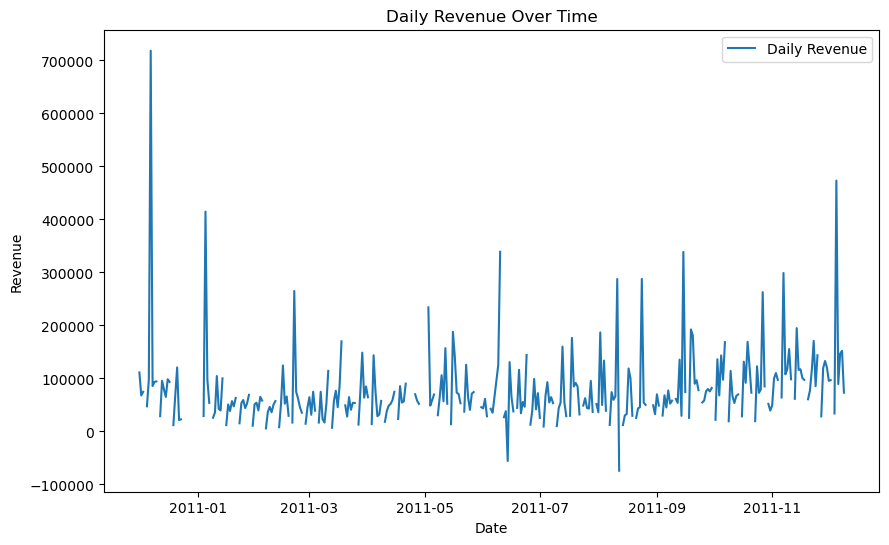

In [40]:
import matplotlib.pyplot as plt

# Plot the daily revenue to visualize trends
plt.figure(figsize=(10,6))
plt.plot(data_daily.index, data_daily['Revenue'], label='Daily Revenue')
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [41]:
data_daily['Revenue'].fillna(method='ffill', inplace=True)  # to remove impute values

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 46, Finished, Available, Finished)

In [42]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize scalers for both features (X) and target (y)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale the features (Revenue)
scaled_X = scaler_X.fit_transform(data_daily[['Revenue']])

# Create sequences from the scaled data
SEQ_LENGTH = 30  # Example: using past 30 days to predict the next day
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Generate sequences
X, y = create_sequences(scaled_X, SEQ_LENGTH)

# Reshape y for scaling and scale it
y = y.reshape(-1, 1)
scaled_y = scaler_y.fit_transform(y)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train_scaled, X_test_scaled = X[:train_size], X[train_size:]
y_train_scaled, y_test_scaled = scaled_y[:train_size], scaled_y[train_size:]


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 47, Finished, Available, Finished)

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define your LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,
    batch_size=64,
    validation_split=0.2,  # Reserve 20% of training data for validation
    verbose=1
)


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 48, Finished, Available, Finished)

Epoch 1/20
4/4 [==============================] - 2s 228ms/step - loss: 0.0784 - val_loss: 0.0645
Epoch 2/20
4/4 [==============================] - 0s 56ms/step - loss: 0.0423 - val_loss: 0.0335
Epoch 3/20
4/4 [==============================] - 0s 51ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 4/20
4/4 [==============================] - 0s 67ms/step - loss: 0.0113 - val_loss: 0.0212
Epoch 5/20
4/4 [==============================] - 0s 63ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 6/20
4/4 [==============================] - 0s 53ms/step - loss: 0.0111 - val_loss: 0.0169
Epoch 7/20
4/4 [==============================] - 0s 47ms/step - loss: 0.0101 - val_loss: 0.0179
Epoch 8/20
4/4 [==============================] - 0s 70ms/step

In [65]:
# Make predictions
predictions = model.predict(X_test_scaled)

# Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler_y.inverse_transform(predictions)
y_test_scaled_inv = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 70, Finished, Available, Finished)

9/9 [==============================] - 0s 15ms/step
Mean Squared Error: 30842721.094929967
Mean Absolute Error: 5540.708280450319


In [75]:
!pip install keras-tuner

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Define a function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()

    # Tuning the number of LSTM units
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

    # Output layer for regression
    model.add(Dense(1))  

    # Tuning the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

# Set up Keras Tuner to do Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='/tmp/hyperparameter_tuning',  # Change this to a directory you have access to
    project_name='lstm_sales_forecasting'
)


# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train_scaled,
             epochs=20,  # You can tune epochs as well if needed
             batch_size=64,  # Tune the batch size too, but keeping it constant here for simplicity
             validation_split=0.2,  # 20% of data for validation
             verbose=1)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_hyperparameters.values}")

# Train the best model again on the full dataset (Optional)
history = best_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Trial 5 Complete [00h 00m 53s]
val_loss: 0.006116244476288557

Best val_loss So Far: 0.006016827343652646
Total elapsed time: 00h 05m 26s
Best hyperparameters: {'units': 50, 'learning_rate': 0.006336077696202977}
Epoch 1/20
15/15 [==============================] - 3s 85ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 2/20
15/15 [==============================] - 1s 42ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 3/20
15/15 [==============================] - 1s 41ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 4/20
15/15 [==============================] - 1s 45ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 5/20
15/15 [==============================] - 1s 45ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 6/20
15/15 [==============================] - 1s 53ms/step - loss: 0.0058 - val_loss: 0.0

In [76]:
# Make predictions
predictions = model.predict(X_test_scaled)

# If your y_test_scaled is scaled, reverse the scaling
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate evaluation metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 81, Finished, Available, Finished)

9/9 [==============================] - 0s 17ms/step
Mean Squared Error: 0.023174850108224943
Mean Absolute Error: 0.14055913061197708


StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 85, Finished, Available, Finished)

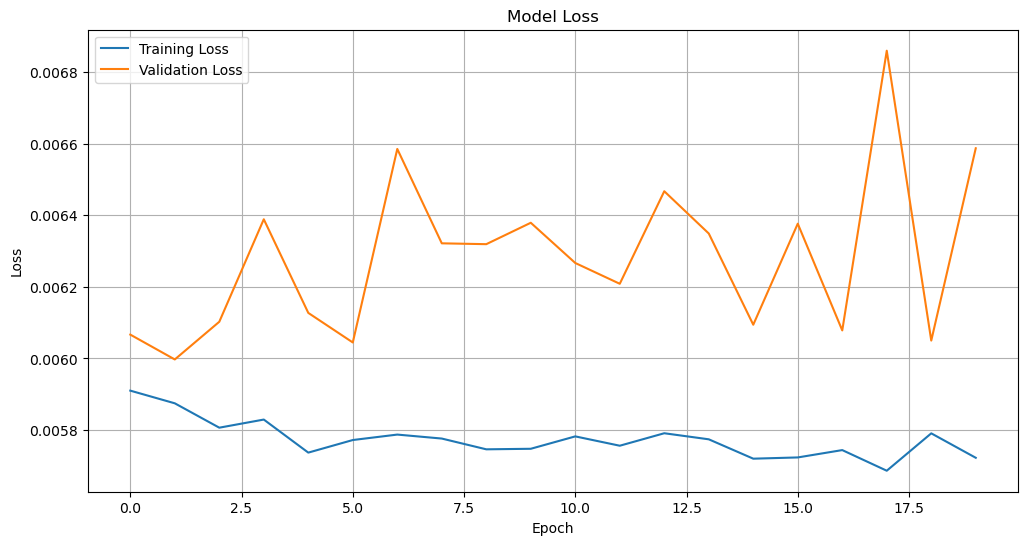

In [80]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Training loss
plt.plot(history.history['loss'])
# Validation loss
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(True)
plt.show()


In [81]:
model.save('lstm_sales_model.h5')

StatementMeta(61faeae0-f889-4e44-aa8e-c51ade462ab5, 28, 86, Finished, Available, Finished)